# Gathering the player ratings data - File in early stages

# Scanning Data

In [32]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import seaborn as sns
import tensorflow.compat.v1 as tf

In [33]:
# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git -q
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

Installing Altair...
Done installing Altair.


You should consider upgrading via the 'c:\users\18053\anaconda3\python.exe -m pip install --upgrade pip' command.


In [34]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

In [35]:
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [36]:
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

In [37]:
df = pd.read_csv('player_ratings.csv')

In [38]:
df.head()

,game_id,user,rating
0,1,jackcres,10.0
1,1,FuManchu,10.0
2,1,HankM,10.0
3,1,jonnypolite,10.0
4,1,pwotruba,10.0


In [39]:
num_ratings = pd.pivot_table(df, index=['user'], values=['rating'], aggfunc='count')
num_ratings.reset_index(inplace=True)
num_ratings.columns = ['user','ratings']
num_ratings.sort_values('ratings', ascending=False).head(10)

,user,ratings
282439,stoneart69,377
271005,ryansmum2008,375
36706,Doel,375
66153,JasonSaastad,374
106101,Pandorzecza,373
52633,Gibmaatsuki,372
233284,leffe dubbel,372
297318,we3die,361
295537,vincivader,350
259357,pete100,348


In [40]:
num_ratings[num_ratings['ratings'] > -1].shape[0], num_ratings[num_ratings['ratings'] > 10].shape[0]

(304441, 108991)

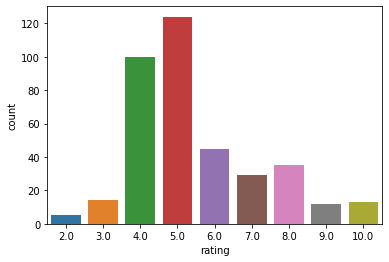

In [41]:
sns.countplot(data=df[df['user'] == 'stoneart69'], x = 'rating')

In [42]:
df['rating_int'] = df['rating'].astype(int)

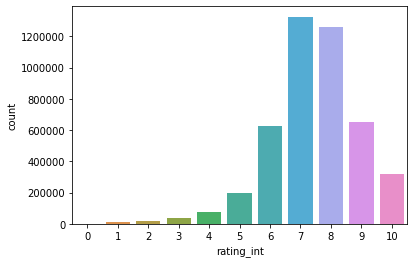

In [43]:
sns.countplot(data = df, x = 'rating_int')

In [44]:
df['approve'] = np.where(df['rating'] >= 7, 1, 0)

# Recommender System Setup

In [47]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [48]:
ratings = df.merge(num_ratings, on ='user')
ratings = ratings[ratings['ratings'] > 10]
ratings.head()

,game_id,user,rating,rating_int,approve,ratings
0,1,jackcres,10.0,10,1,31
1,1035,jackcres,8.0,8,1,31
2,1041,jackcres,8.0,8,1,31
3,11,jackcres,6.0,6,0,31
4,110327,jackcres,6.0,6,0,31


In [49]:
from collections import defaultdict

def return_negative_one():
    return -1
    
user_dict = defaultdict(return_negative_one)
game_dict = defaultdict(return_negative_one)

In [50]:
i = 0
for u in ratings['user'].unique():
    user_dict[u] = i
    i += 1

In [51]:
i = 0
for u in ratings['game_id'].unique():
    game_dict[u] = i
    i += 1

In [52]:
ratings['user_idx'] = ratings['user'].apply(lambda x: user_dict[x])
ratings['game_idx'] = ratings['game_id'].apply(lambda x: game_dict[x])
ratings.head()

,game_id,user,rating,rating_int,approve,ratings,user_idx,game_idx
0,1,jackcres,10.0,10,1,31,0,0
1,1035,jackcres,8.0,8,1,31,0,1
2,1041,jackcres,8.0,8,1,31,0,2
3,11,jackcres,6.0,6,0,31,0,3
4,110327,jackcres,6.0,6,0,31,0,4


In [53]:
ratings.dtypes

game_id         int64
user           object
rating        float64
rating_int      int32
approve         int32
ratings         int64
user_idx        int64
game_idx        int64
dtype: object

In [54]:
ratings.shape[0], ratings['user_idx'].max(), ratings['user_idx'].nunique()

(3801461, 108990, 108991)

In [55]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_idx', 'game_idx']].values
  values_ = ratings_df['rating_int'].values
  return tf.SparseTensor(
      indices=indices,
      values=values_,
      dense_shape=[ratings_df['user_idx'].nunique(), ratings_df['game_idx'].nunique()])

In [56]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [57]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [58]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_idx": U,
      "game_idx": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [59]:
train_ratings, test_ratings = split_dataframe(ratings)
# SparseTensor representation of the train and test datasets.
A_train = build_rating_sparse_tensor(train_ratings)
A_test = build_rating_sparse_tensor(test_ratings)

 iteration 500: train_error=1.676016, test_error=1.87729976

[{'train_error': 1.6760159, 'test_error': 1.8772994}]

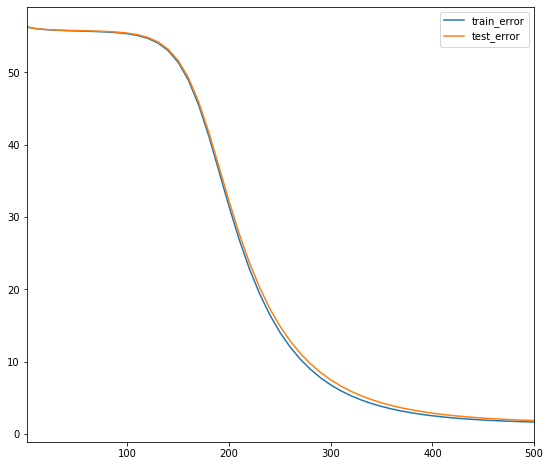

In [88]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=10, init_stddev=0.5)
model.train(num_iterations=350, learning_rate=10.)

 iteration 350: train_error=2.266076, test_error=2.44914212

[{'train_error': 2.2660758, 'test_error': 2.4491425}]

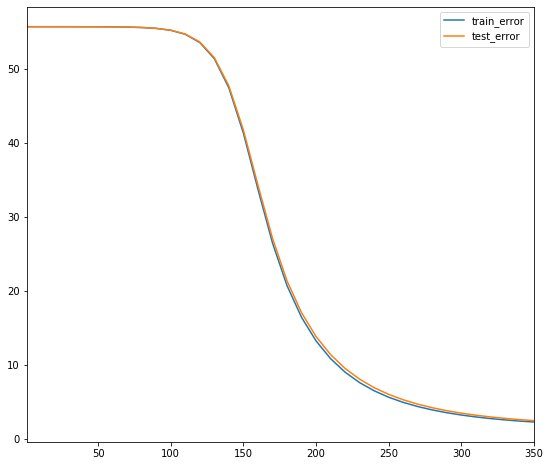

In [92]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=3, init_stddev=0.1)
model.train(num_iterations=350, learning_rate=10.)

# Testing Recommender Performance

In [61]:
#itle Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [62]:
import sqlite3
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [63]:
#results = cur.execute('SELECT * FROM TOP_GAMES_FULL')
results = cur.execute('PRAGMA table_info(TOP_GAMES_FULL)')
results = results.fetchall()
result_li = [r for r in results]
column_li = []
for r in result_li:
    column_li.append(r[1])

print(column_li)

['id', 'title', 'year', 'min_players', 'max_players', 'avg_rating', 'avg_bayes_rating', 'std', 'ratings', 'weight', 'play_time']


In [64]:
results = cur.execute('SELECT * FROM TOP_GAMES_FULL')
results = results.fetchall()
result_li = [r for r in results]
df = pd.DataFrame(result_li, columns = column_li)
df.head()

,id,title,year,min_players,max_players,avg_rating,avg_bayes_rating,std,ratings,weight,play_time
0,174430,gloomhaven,2017,1,4,8.76798,8.53089,1.63005,45304,3.8673,120
1,161936,pandemic_legacy_season_1,2015,2,4,8.60479,8.45273,1.56467,43525,2.836,60
2,224517,brass_birmingham,2018,2,4,8.66929,8.406,1.24659,22694,3.9084,120
3,167791,terraforming_mars,2016,1,5,8.4247,8.27852,1.38438,69921,3.244,120
4,291457,gloomhaven_jaws_lion,2020,1,4,8.7573,8.2579,1.40857,12633,3.559,120


In [65]:
df['game_idx'] = df['id'].apply(lambda x: game_dict[int(x)])
games = df[df['game_idx'] >= 0]
games = games[['game_idx', 'title', 'year', 'weight', 'play_time', 'ratings']]

In [66]:
def game_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  games.loc[games['title'].str.contains(title_substring), ['game_idx']].values
  ids = list(ids.flatten())
  titles = games.loc[games['game_idx'].isin(ids), 'title'].values
  if len(titles) == 0:
    raise ValueError("Found no games with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching game. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["game_idx"][movie_id], model.embeddings["game_idx"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': games['title']
      #'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [67]:
game_neighbors(model, "bohnanza", COSINE, k=6)

Nearest neighbors of : bohnanza.


,cosine score,titles
7,1.000000,star_wars_rebellion
238,0.999950,manhattan_project_energy_empire
24,0.999945,orleans
17,0.999943,concordia
293,0.999938,evolution_climate
403,0.999930,raptor


In [68]:
game_neighbors(model, "orleans", DOT, k= 6)

Nearest neighbors of : orleans.


,dot score,titles
646,112.537239,among_stars
99,111.420212,roll_galaxy
59,109.211906,android_netrunner
581,106.819901,vegas_showdown
15,106.691055,7_wonders_duel
73,106.571899,five_tribes


Dot product recommends the same games no matter what. Cosine seems to perform much better

# Adjusting Model

In [69]:
def game_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': games['title'],
      'num_ratings': games['user_ratings'],
  })
  df['num_ratings'] = df['num_ratings'].astype(int)
  #df['num_ratings'] = df['num_ratings'].apply(lambda x: np.log(x))
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["game_idx"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df), df

In [70]:
if not 'user_ratings' in games.columns:
    num_of_game_ratings = pd.pivot_table(data=ratings, index = ['game_idx'], values = ['user'], aggfunc='count')
    num_of_game_ratings.reset_index(inplace=True)
    num_of_game_ratings.columns = ['game_idx', 'user_ratings']
    games = games.merge(num_of_game_ratings, on = 'game_idx')
    games.head()

In [71]:
games.head()

,game_idx,title,year,weight,play_time,ratings,user_ratings
0,244,gloomhaven,2017,3.8673,120,45304,30333
1,43,pandemic_legacy_season_1,2015,2.836,60,43525,34807
2,25,terraforming_mars,2016,3.244,120,69921,51899
3,30,star_wars_rebellion,2016,3.7216,240,24459,20138
4,224,through_ages_new_story_civilization,2015,4.4062,120,24493,21548


In [72]:
thing, _ = game_embedding_norm(model)

In [73]:
_

,title,num_ratings,norm0
0,gloomhaven,30333,8.189427
1,pandemic_legacy_season_1,34807,3.354197
2,terraforming_mars,51899,7.136006
3,star_wars_rebellion,20138,8.947441
4,through_ages_new_story_civilization,21548,9.808330
...,...,...,...
368,explorers_north_sea,2106,4.724884
369,la_isla,5011,3.781393
370,blueprints,6017,5.378907
371,prodigals_club,2175,3.691300


In [121]:
results = cur.execute('''
WITH inner_query AS (
SELECT id, category, ROW_NUMBER() OVER (PARTITION BY id)  r

FROM BGG_CATEGORIES)

SELECT id game_id, category

FROM inner_query

WHERE 1=1
    --AND r = 1

''')
results = results.fetchall()
result_li = [r for r in results]
game_genres = pd.DataFrame(result_li, columns = ['game_id', 'genre'])
game_genres['game_idx'] = game_genres['game_id'].apply(lambda x: game_dict[int(x)])
game_genres.head()

,game_id,genre,game_idx
0,1,Economic,0
1,1,Negotiation,0
2,1,Political,0
3,100423,Adventure,72
4,100423,Card Game,72


In [122]:
top_10_genres = pd.pivot_table(game_genres
                ,index=['genre']
                ,values = ['game_idx']
                ,aggfunc='count').sort_values('game_idx',
                                            ascending=False,).head(10).index

In [123]:
game_genres['Top'] = game_genres['genre'].isin(top_10_genres).astype(int)

In [124]:
game_genres.sort_values(['game_id','Top'], ascending=[True, False], inplace=True)

In [125]:
game_genres.drop_duplicates(subset=['game_id'], keep='first', inplace=True)

In [127]:
game_genres.loc[game_genres['Top'] == 0, 'genre'] = 'Other'

In [128]:
del game_genres['Top']

In [129]:
try:
    del games['genre']
except KeyError:
    pass

In [130]:
games = games.merge(game_genres, on = ['game_idx'], how='left')
games.head()

,game_idx,title,year,weight,play_time,ratings,user_ratings,x,y,game_id_x,game_id_y,genre
0,244,gloomhaven,2017,3.8673,120,45304,30333,-10.678903,4.460822,174430,174430,Adventure
1,43,pandemic_legacy_season_1,2015,2.836,60,43525,34807,-9.037819,-10.643716,161936,161936,Other
2,25,terraforming_mars,2016,3.244,120,69921,51899,6.062011,-13.758048,167791,167791,Economic
3,30,star_wars_rebellion,2016,3.7216,240,24459,20138,9.155114,4.499483,187645,187645,Fighting
4,224,through_ages_new_story_civilization,2015,4.4062,120,24493,21548,-4.201438,15.760880,182028,182028,Card Game


In [131]:
games.loc[pd.isna(games['genre']), 'genre'] = 'Other'

In [132]:
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [133]:
def visualize_game_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

In [134]:
def tsne_game_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["game_idx"])
  print('ARRAY SIZES')
  #print(len(games.loc[:,'x']), len(V_proj[:, 0]))  
    
  games.loc[:,'x'] = V_proj[:, 0]
  games.loc[:,'y'] = V_proj[:, 1]
  return visualize_game_embeddings(games, 'x', 'y')

In [135]:
tsne_game_embeddings(model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 373 samples in 0.000s...
[t-SNE] Computed neighbors for 373 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 373 / 373
[t-SNE] Mean sigma: 0.004904
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.917389
[t-SNE] KL divergence after 400 iterations: 0.308815
ARRAY SIZES


alt.HConcatChart(...)

In [85]:
# model_lowinit = build_model(ratings, embedding_dim=3, init_stddev=0.25)
# model_lowinit.train(num_iterations=100, learning_rate=20.)
# movie_neighbors(model_lowinit, "gloomhaven", DOT)
# movie_neighbors(model_lowinit, "gloomhaven", COSINE)
# movie_embedding_norm([model, model_lowinit])

# Scratch Code